# Chapter 4: Field data study Rockeskyller Kopf
# Data preparation and visualization


<div class="alert alert-success">
    
This Notebook shows how data is setup and how the mesh is created. It also shows the data and the acquistion setup as weell as the mesh.

In [1]:
# %% IMPORTS
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import pygimli           as pg
import pygimli.meshtools as mt
import cmasher           as cmr
import functools
import warnings

from pygimli.viewer             import pv
from pygimli.physics.gravimetry import MagneticsModelling
from pygimli.physics.gravimetry import SolveGravMagHolstein
from pygimli.physics            import ert
from scipy.interpolate          import griddata
from AZ_pygimli_3DTopo          import *
from PlotFunctions_Ch5          import *

warnings.filterwarnings("ignore")
%matplotlib qt

### Parameters and names

In [2]:
path = 'C:/Users/azieg/Documents/GitHub/JMEI_Paper/'

fig_dir = path+'Figures/Ch-4/'
fn_dir  = path+'Data/Rockeskyll/'

fn_magnetic = 'Magnetic_data_corrected.csv'

fn1='ERT_raw/line1_dip.dat'
fn2='ERT_raw/line2_dip.dat'
fn3='ERT_raw/line3_dip.dat'
fn4='ERT_raw/line4_dip.dat'
geo1='Geo/2023_ERTL1_Locations.csv'
geo2='Geo/2023_ERTL2_Locations.csv'
geo3='Geo/2023_ERTL3_Locations.csv'
geo4='Geo/2023_ERTL4_Locations.csv'

geo_gp ='Geo/2016_Seis_GP_Locations.csv'
geo_shot ='Geo/2016_Seis_SHOT_Locations.csv'

# %% PARAMETERS (based on Boxberg 2011)
F = 48487.4   # Median field intensity in nT
I = 65.70     # Median inclination
D = 0.85      # Median declination

xex = [2.54902*1e6, 2.54920*1e6] #x-extent
yex = [5.56930*1e6, 5.56950*1e6] #y-extent
zex = [400, 460]             #z-axtent

dx = 1 # topography point shift for surface mesh creation
dy = 1 # topography point shift for surface mesh creation

abserr = 5e-5 #ERT absolute error
relerr  = 0.03 # ERT relative error

n_lines = 4 # number of lines

# Plotting
c_ert = 'gnuplot'
c_mag = cmr.tropical
lim_pseudos = [18,180]

### Importing Seismic Geometry

In [3]:
df_gp = pd.read_csv(fn_dir+geo_gp, delimiter=' ', decimal='.',header=None)
p_gp = np.array([[df_gp[1][i], df_gp[2][i], df_gp[3][i]] for i in range(len(df_gp))])
df_shot = pd.read_csv(fn_dir+geo_shot, delimiter=' ', decimal='.',header=None)
p_shot = np.array([[df_shot[1][i], df_shot[2][i], df_shot[3][i]] for i in range(len(df_shot))])

### Importing Magnetic Data and Geometry

In [4]:
# %% READING DATA CSV-FILE
df = pd.read_csv(fn_dir+fn_magnetic, delimiter=',', decimal='.')
d_obs = df['F'].to_numpy()-F                                           # Total Field Anomaly numpy array
d_mag = pg.Vector(d_obs)                                                # Total Field Anomaly RVector
noise = df['noise'].to_numpy()

# %% EXTRACT SENSOR POSITIONS
pnts = np.array([[df['X'][i], df['Y'][i], df['Z'][i]] for i in range(len(df))])

# %% Show Mag data
fig,ax = plt.subplots()
mm = np.max(np.abs(d_obs))
im = ax.scatter(pnts[:,0], pnts[:,1], c=d_obs, marker='8', cmap="PuOr", vmin=-mm, vmax=mm)
ax.set_title('Measured Data')
ax.set_ylabel('Northing in m')
ax.set_xlabel('Easting in m')
cb = fig.colorbar(im, ax=ax, orientation='vertical')
cb.ax.set_title('TFA\nnT')

Text(0.5, 1.0, 'TFA\nnT')

create surface points that are shifted by dx in x direction and dy in y direction
This is needed as for the forward operator observation points are not allowed to be
on the nodes or boundaries but must be inside a triangular boundary!!!

In [5]:
pnts_new = np.zeros((len(pnts),3))

pnts_new[:,0] = np.array(pnts[:,0]) + np.ones(len(pnts))*dx
pnts_new[:,1] = np.array(pnts[:,1]) + np.ones(len(pnts))*dy

# Interpolate the elevation of new surface points
Z_new = griddata((pnts[:,0], pnts[:,1]), pnts[:,2], (pnts_new[:,0], pnts_new[:,1]), method='linear')

# Interpolate points that cannot be interpolated with linear method --> use nearest instead
nan = np.argwhere(np.isnan(Z_new))[:,0].tolist()
Z_nearest = griddata((pnts[:,0], pnts[:,1]), pnts[:,2], (pnts_new[nan,0], pnts_new[nan,1]), method='nearest')
Z_new[nan] = Z_nearest

pnts_new[:,2] = Z_new

### Importing ERT Geometry

In [6]:
df1 = pd.read_csv(fn_dir+geo1, delimiter=',', decimal='.')
p1 = np.array([[df1['X'][i], df1['Y'][i], df1['Z'][i]] for i in range(len(df1))])

df2 = pd.read_csv(fn_dir+geo2, delimiter=',', decimal='.')
p2 = np.array([[df2['X'][i], df2['Y'][i], df2['Z'][i]] for i in range(len(df2))])

df3 = pd.read_csv(fn_dir+geo3, delimiter=',', decimal='.')
p3 = np.array([[df3['X'][i], df3['Y'][i], df3['Z'][i]] for i in range(len(df3))])
p3 = p3[:-1,:] # This array has one electrode too much :(

df4 = pd.read_csv(fn_dir+geo4, delimiter=',', decimal='.')
p4 = np.array([[df4['X'][i], df4['Y'][i], df4['Z'][i]] for i in range(len(df4))])

### Importing ERT Data

In [7]:
remove_elecs = True

In [8]:
# 3D ERT Data
data1 = ert.load(fn_dir+fn1)
data2 = ert.load(fn_dir+fn2)
data3 = ert.load(fn_dir+fn3)
data4 = ert.load(fn_dir+fn4)

p_ertlines = [p1, p2, p3, p4]
for i,d in enumerate([data1, data2, data3, data4]):
    d.setSensorPositions(p_ertlines[i])
    
    # Remove backward measurements
    d.markInvalid(d['a'] > d['b'] )
    d.markInvalid(d['m'] > d['n'] )
    d.removeInvalid()
    
    # Convert to apparent resistivities
    d['k'] = ert.createGeometricFactors(d, numerical=True, dim=3)
    d['rhoa'] = d['k']*d['u']/d['i']
    d['err'] = ert.estimateError(d, absoluteUError=abserr, relativeError=relerr)
    
# 2D ERT Data with Topo
el_2D = []

data1_2d = ert.load(fn_dir+fn1)
data2_2d = ert.load(fn_dir+fn2)
data3_2d = ert.load(fn_dir+fn3)
data4_2d = ert.load(fn_dir+fn4)

if remove_elecs:
    for d in [data4, data4_2d]:
        for e in [40]:
            d.markInvalid(d['a']==e)
            d.markInvalid(d['b']==e)
            d.markInvalid(d['m']==e)
            d.markInvalid(d['n']==e)
            d.removeInvalid()

data_3d = [data1,data2,data3,data4]
for i,d in enumerate([data1_2d, data2_2d, data3_2d, data4_2d]):
    # Set Topo
    el = np.array(d.sensorPositions())
    el[:,2] = p_ertlines[i][:,2]
    d.setSensorPositions(el)
    el_2D.append(el) # save into array
    
    # Remove backward measurements
    d.markInvalid(d['a'] > d['b'] )
    d.markInvalid(d['m'] > d['n'] )
    d.removeInvalid()
    
    # Convert to apparent resistivities
    d['k'] = data_3d[i]['k']
    d['rhoa'] = data_3d[i]['rhoa']
    d['err'] = data_3d[i]['err']

# Combining all 3d ERT Data into one DataContainer
d_all = ert.DataContainer()
p_all = p1.tolist() + p2.tolist() + p3.tolist() + p4.tolist() 
d_all.setSensorPositions(p_all)

add_list = [0,len(p1),len(p1)+len(p2),len(p1)+len(p2)+len(p3)] # is to add to sensorindices of corresponding line to avoid multiple sensord with same indices
for i,d in enumerate(data_3d):
    a = add_list[i]
    
    for j in range(len(d['a'])):
        d_all.addFourPointData([d['a'][j]+a,
                                d['b'][j]+a,
                                d['m'][j]+a,
                                d['n'][j]+a], rhoa=d['rhoa'][j], k=d['k'][j], err=d['err'][j])

25/07/23 - 10:07:32 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (6.2s x 24): C:\Users\azieg\AppData\Roaming\pygimli\Cache\10431693019552665568
25/07/23 - 10:07:32 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (6.9s x 24): C:\Users\azieg\AppData\Roaming\pygimli\Cache\17232826491180889645
25/07/23 - 10:07:32 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (5.5s x 24): C:\Users\azieg\AppData\Roaming\pygimli\Cache\18195954076334133931
25/07/23 - 10:07:32 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (7.2s x 23): C:\Users\azieg\AppData\Roaming\pygimli\Cache\16271641441757171142


### Show merged ERT Data

Text(276, 0.5, 'W')

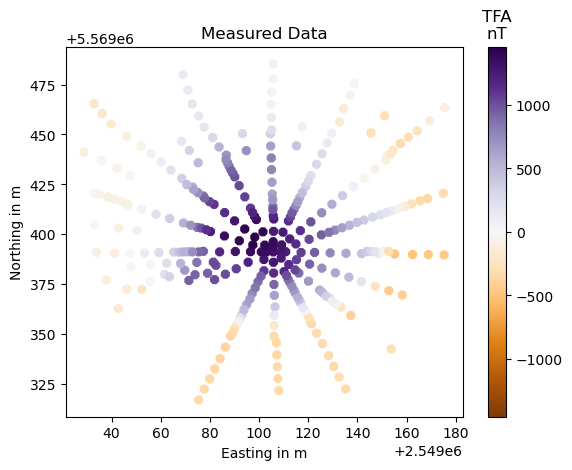

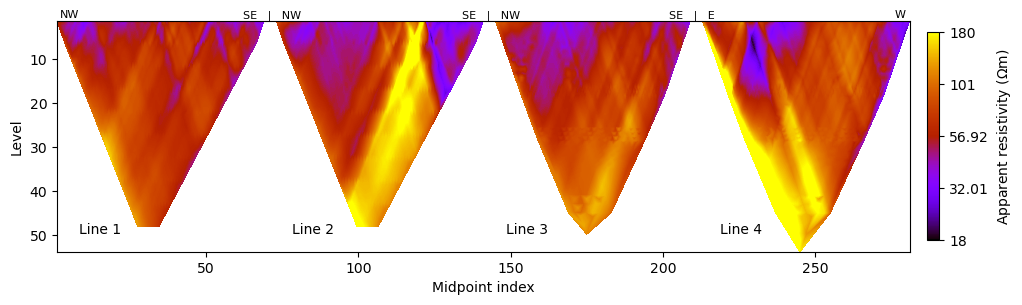

In [9]:
# Index list for Plotting function
idx_list = [0,len(data1.dataIndex()),
            len(data1.dataIndex()) + len(data2.dataIndex()),
            len(data1.dataIndex()) + len(data2.dataIndex()) + len(data3.dataIndex()),
            len(data1.dataIndex()) + len(data2.dataIndex()) + len(data3.dataIndex()) + len(data4.dataIndex())]

# PLOT PSEUDOSECTIONS
%matplotlib inline
fig, ax = plt.subplots(figsize=(11,3))
showPseudosections(d_all, d_all['rhoa'].array(), idx_list, 4, ax=ax, clim=lim_pseudos, cmap=c_ert)

y = .5
ax.text(2,y,'NW', fontsize=8)
ax.text(62,y,'SE   |   NW', fontsize=8)
ax.text(134,y,'SE   |   NW', fontsize=8)
ax.text(202,y,'SE   |   E', fontsize=8)
ax.text(276,y,'W', fontsize=8)

# plt.savefig(fig_dir+'ERT_2023_Pseudos.png', dpi=600, bbox_inches='tight')

### Save final data

In [42]:
d_all.save(fn_dir+'ert_data_rockes_all')

data1_2d.save(fn_dir+'ert_data_2d_1')
data2_2d.save(fn_dir+'ert_data_2d_2')
data3_2d.save(fn_dir+'ert_data_2d_3')
data4_2d.save(fn_dir+'ert_data_2d_4')

1

### Create Mesh

In [43]:
topo = p1.tolist() + p2.tolist() + p3.tolist() + p4.tolist() + pnts_new.tolist()

x = np.linspace(xex[0], xex[1], 3)
y = np.linspace(yex[0], yex[1], 3)
z = np.ones(len(x))*np.mean(pnts[:,2])
sensors = np.asarray([x, y, z]).T

vol = AZ_createParaMeshPLC3D(sensors,
                              paraDX=0,
                              paraDepth=40,
                              boundary=[1,1],
                              surfaceMeshQuality=30,
                              addTopo=topo)


mesh = mt.createMesh(vol, area=100)

for bound in mesh.boundaries():
    if bound.marker()==1:
        bound.setMarker(-2)
        
print(mesh)

Mesh: Nodes: 8381 Cells: 40005 Boundaries: 83717


In [14]:
%matplotlib widget

pl, _ = pg.show(mesh, style='wireframe', hold=True, alpha=0.5, bc='lightgray', notebook=False)
pv.drawSensors(pl, pnts, diam=3, color='blue')
pv.drawSensors(pl, p1, diam=2, color='darkolivegreen')
pv.drawSensors(pl, p2, diam=2, color='limegreen')
pv.drawSensors(pl, p3, diam=2, color='springgreen')
pv.drawSensors(pl, p4, diam=2, color='aquamarine')
pl.add_title('Inversion mesh') 
pl.show()

In [15]:
%matplotlib widget

z_center = pg.z(mesh.cellCenters())
z_center[z_center<420] = 420

pl, _ = pg.show(mesh,z_center, hold=True, alpha=1, bc='lightgray', notebook=False, cMap='Greys', label='Eleveation (m asl)')
pv.drawSensors(pl, pnts, diam=2, color='blue')
pv.drawSensors(pl, p1, diam=2, color='darkolivegreen')
pv.drawSensors(pl, p2, diam=2, color='limegreen')
pv.drawSensors(pl, p3, diam=2, color='springgreen')
pv.drawSensors(pl, p4, diam=2, color='aquamarine')
pl.add_title('Inversion mesh') 
pl.show()

In [44]:
%matplotlib widget

pl, _ = pg.show(mesh, style='wireframe', hold=True, alpha=0.5, bc='lightgray', notebook=False)
pv.drawSensors(pl, pnts, diam=3, color='blue')
pv.drawSensors(pl, p1, diam=2, color='darkolivegreen')
pv.drawSensors(pl, p2, diam=2, color='limegreen')
pv.drawSensors(pl, p3, diam=2, color='springgreen')
pv.drawSensors(pl, p4, diam=2, color='aquamarine')
pl.add_title('Inversion mesh') 
pl.show()

In [28]:
# %% Save mesh
# mesh.save(fn_dir+'invmesh')

1

### Interpolation for display


In [18]:
# Topography interpolation
Xs=[];Ys=[];Zs=[]

for p in [pnts,p1,p2,p3,p4]:
    Xs += p[:,0].tolist() 
    Ys += p[:,1].tolist() 
    Zs += p[:,2].tolist() 
    
xnew,ynew =  np.meshgrid(np.linspace(xex[0], xex[1], 100),np.linspace(yex[0], yex[1], 100))
znew = griddata((Xs, Ys), Zs, (xnew, ynew), method='linear')

# Noise into rel error
relError = np.zeros(len(df)) # calculate relative error
for i in range(len(df)):
    relError[i] = abs(noise[i]/d_mag[i])+0.02 # additional 2% rel error

# Magnetic data interpolation
Fi_new = griddata((pnts[:,0].tolist(), pnts[:,1].tolist()), d_obs.tolist(), (xnew, ynew), method='linear')
# Noise_new = griddata((pnts[:,0].tolist(), pnts[:,1].tolist()), df['noise'].tolist(), (xnew, ynew), method='linear')
Noise_new = griddata((pnts[:,0].tolist(), pnts[:,1].tolist()), relError, (xnew, ynew), method='linear')

### Fig. 9: Acquisition geometry in 2D

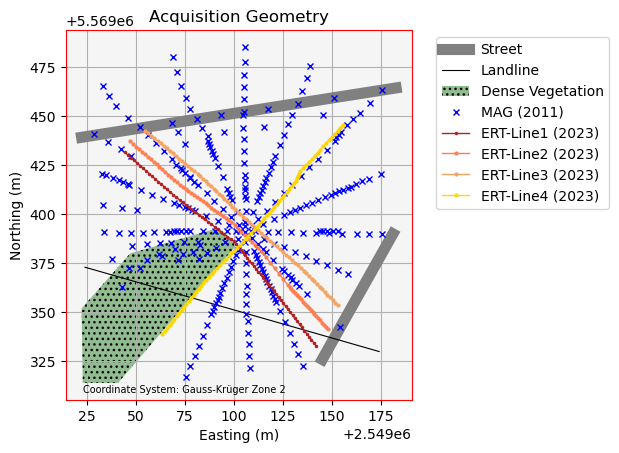

In [16]:
%matplotlib inline
from matplotlib.patches import Polygon


fig,ax = plt.subplots()
# ax.contourf(xnew,ynew,znew,cmap='Greys', levels=500)

# Street
ax.plot([2549022.3, 2549182.638], [5569439.232,5569464.406], lw=8, c='grey', label='Street')
ax.plot([2549181, 2549145], [5569390,5569326], lw=8, c='grey')

# Landline
ax.plot([2549024, 2549174], [5569373,5569330], lw=.8, c='black', label='Landline')
2549080

# Vegetation
veg = Polygon([(2549022.3,5569352), (2549022.868,5569314), (2549040.853,5569314),(2549101.067,5569384),(2549092,5569393),(2549047,5569380)]
              , label='Dense Vegetation', fc='darkseagreen',  hatch='...', alpha=.99)
ax.add_patch(veg)

# Sensors
mag = ax.plot(pnts[:,0], pnts[:,1], color = "blue", marker='x', linestyle = 'None', markersize=4, label='MAG (2011)')
# s2016g = ax.plot(p_gp[:,0], p_gp[:,1], color = "purple", marker='v', linestyle = 'None', markersize=2, label='SRT-rec (2016)')
# s2016s = ax.plot(p_shot[:,0], p_shot[:,1], color = "deeppink", marker='4', linestyle = 'None', markersize=4, label='SRT-shot (2016)')
e2023l1 = ax.plot(p1[:,0], p1[:,1], color = "firebrick", marker='.', lw=1, markersize=3, label='ERT-Line1 (2023)')
e2023l2 = ax.plot(p2[:,0], p2[:,1], color = "coral", marker='.', lw=1, markersize=4, label='ERT-Line2 (2023)')
e2023l3 = ax.plot(p3[:,0], p3[:,1], color = "sandybrown", marker='.', lw=1, markersize=4, label='ERT-Line3 (2023)')
e2023l4 = ax.plot(p4[:,0], p4[:,1], color = "gold", marker='.', lw=1, markersize=4, label='ERT-Line4 (2023)')

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('Acquisition Geometry')
ax.text(2549023,5569309,'Coordinate System: Gauss-Krüger Zone 2', fontsize=7)
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_aspect('equal', 'box')

for spine in ax.spines.values():
    spine.set_edgecolor('red')

ax.set_facecolor('whitesmoke')
ax.grid()

# plt.savefig(fig_dir+'Acquisition.png', dpi=600, bbox_inches='tight')

### Surface in 3D 

In [75]:
from mpl_toolkits         import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib           import cm

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Elevation (m asl)')

ax.set_box_aspect([1,1,0.4])

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap='Greys', linewidth=0, alpha=0.85)
cbar = fig.colorbar(surf, orientation="horizontal", pad=0.2)
cbar.set_label('Elevation above m.s.l.')

### Magnetics data

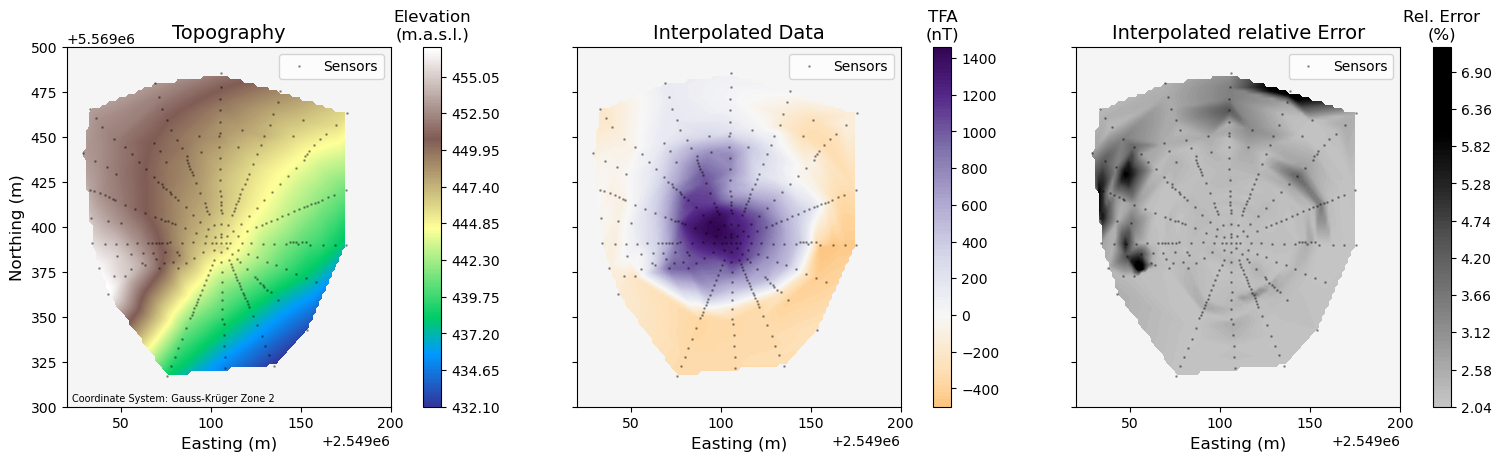

In [24]:
fig,ax = plt.subplots(1,3, figsize=(15, 4.5), sharex=True, sharey=True, constrained_layout=True)

im1 = ax[0].contourf(xnew,ynew,znew,cmap='terrain', levels=500, vmin=432, vmax=457)
im2 = ax[1].contourf(xnew,ynew,Fi_new,cmap='PuOr', levels=100, vmin=-1500, vmax=1500)
im3 = ax[2].contourf(xnew,ynew,Noise_new*100,cmap='Greys', levels=100,vmin=0, vmax=+6)

cb1 = plt.colorbar(im1, ax=ax[0])
cb2 = plt.colorbar(im2, ax=ax[1])
cb3 = plt.colorbar(im3, ax=ax[2])

cb1.ax.set_title('Elevation\n(m.a.s.l.)')
cb2.ax.set_title('TFA\n(nT)')
cb3.ax.set_title('Rel. Error\n(%)')

# Sensors
for a in [0,1,2]:
    ax[a].plot(pnts[:,0], pnts[:,1], color = "black", marker='.', linestyle = 'None', markersize=2, alpha=0.3, label='Sensors')
    ax[a].legend()
    ax[a].set_facecolor('whitesmoke')

for a in ax:
    a.set_xlabel('Easting (m)', fontsize=12)
ax[0].set_ylabel('Northing (m)', fontsize=12)

ax[0].set_title('Topography', fontsize=14)
ax[1].set_title('Interpolated Data', fontsize=14)
ax[2].set_title('Interpolated relative Error', fontsize=14)

ax[0].text(2549023,5569303,'Coordinate System: Gauss-Krüger Zone 2', fontsize=7)

ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[2].set_aspect('equal', 'box')

# plt.savefig(fig_dir+'MAG_data.png', dpi=600, bbox_inches='tight')